## 5 - Convolution Neural Network (Convnet)

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
REBUILD_DATA = True  

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append(
                        [np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats:",self.catcount)
        print("Dogs:",self.dogcount)
        
if REBUILD_DATA:
    dogvcats = DogsVSCats()
    dogvcats.make_training_data()

In [3]:
np.eye(3)[1]

array([0., 1., 0.])

In [4]:
np.eye(3)[2]

array([0., 0., 1.])

In [5]:
REBUILD_DATA = False

In [10]:
training_data = np.load("training_data.npy", allow_pickle=True)

print(len(training_data))

24946


In [8]:
print(training_data[1])

[array([[64, 64, 63, ..., 60, 63, 68],
       [66, 65, 64, ..., 63, 67, 73],
       [65, 65, 65, ..., 70, 74, 77],
       ...,
       [62, 62, 62, ..., 16, 17, 17],
       [59, 60, 60, ..., 14, 15, 19],
       [57, 57, 57, ..., 15, 17, 17]], dtype=uint8)
 array([0., 1.])]


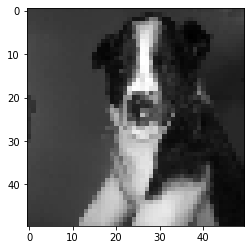

In [9]:
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net=Net()

torch.Size([128, 2, 2])


In [22]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

val_pct = 0.1
val_size = int(len(X)*val_pct)
print(val_size)

2494


In [23]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [29]:
BATCH_SIZE = 100
EPOCHS = 1
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()  # OR model.zero_grad()   OR optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])



  1%|          | 2/225 [00:01<02:29,  1.49it/s]

torch.Size([128, 2, 2])



  1%|▏         | 3/225 [00:01<01:59,  1.86it/s]

torch.Size([128, 2, 2])



  2%|▏         | 4/225 [00:01<01:38,  2.24it/s]

torch.Size([128, 2, 2])



  2%|▏         | 5/225 [00:01<01:23,  2.65it/s]

torch.Size([128, 2, 2])



  3%|▎         | 6/225 [00:02<01:12,  3.01it/s]

torch.Size([128, 2, 2])



  3%|▎         | 7/225 [00:02<01:04,  3.37it/s]

torch.Size([128, 2, 2])



  4%|▎         | 8/225 [00:02<01:00,  3.58it/s]

torch.Size([128, 2, 2])



  4%|▍         | 9/225 [00:02<00:56,  3.80it/s]

torch.Size([128, 2, 2])



  4%|▍         | 10/225 [00:02<00:52,  4.08it/s]

torch.Size([128, 2, 2])



  5%|▍         | 11/225 [00:03<00:48,  4.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  6%|▌         | 13/225 [00:03<00:42,  4.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  7%|▋         | 15/225 [00:03<00:39,  5.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  8%|▊         | 17/225 [00:04<00:38,  5.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  8%|▊         | 19/225 [00:04<00:38,  5.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  9%|▉         | 21/225 [00:04<00:39,  5.19it/s]

torch.Size([128, 2, 2])



 10%|▉         | 22/225 [00:05<00:38,  5.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 11%|█         | 24/225 [00:05<00:37,  5.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 12%|█▏        | 26/225 [00:05<00:38,  5.16it/s]

torch.Size([128, 2, 2])



 12%|█▏        | 27/225 [00:06<00:36,  5.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 13%|█▎        | 29/225 [00:06<00:36,  5.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 14%|█▍        | 31/225 [00:06<00:34,  5.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 15%|█▍        | 33/225 [00:07<00:34,  5.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 16%|█▌        | 35/225 [00:07<00:33,  5.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 16%|█▋        | 37/225 [00:07<00:32,  5.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 17%|█▋        | 39/225 [00:08<00:31,  5.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 18%|█▊        | 41/225 [00:08<00:31,  5.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 19%|█▉        | 43/225 [00:08<00:31,  5.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 20%|██        | 45/225 [00:09<00:30,  5.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 21%|██        | 47/225 [00:09<00:30,  5.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 22%|██▏       | 49/225 [00:09<00:31,  5.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 23%|██▎       | 51/225 [00:10<00:30,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 24%|██▎       | 53/225 [00:10<00:30,  5.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 24%|██▍       | 55/225 [00:10<00:29,  5.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 25%|██▌       | 57/225 [00:11<00:30,  5.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 26%|██▌       | 59/225 [00:11<00:28,  5.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 27%|██▋       | 61/225 [00:11<00:29,  5.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 28%|██▊       | 63/225 [00:12<00:28,  5.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 29%|██▉       | 65/225 [00:12<00:28,  5.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 30%|██▉       | 67/225 [00:13<00:27,  5.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 31%|███       | 69/225 [00:13<00:28,  5.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 32%|███▏      | 71/225 [00:13<00:28,  5.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 32%|███▏      | 73/225 [00:14<00:28,  5.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 33%|███▎      | 75/225 [00:14<00:28,  5.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 34%|███▍      | 77/225 [00:14<00:27,  5.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 35%|███▌      | 79/225 [00:15<00:26,  5.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 36%|███▌      | 81/225 [00:15<00:27,  5.20it/s]

torch.Size([128, 2, 2])



 36%|███▋      | 82/225 [00:15<00:28,  5.07it/s]

torch.Size([128, 2, 2])



 37%|███▋      | 83/225 [00:16<00:28,  5.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 38%|███▊      | 85/225 [00:16<00:27,  5.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 39%|███▊      | 87/225 [00:16<00:27,  4.98it/s]

torch.Size([128, 2, 2])



 39%|███▉      | 88/225 [00:17<00:27,  4.90it/s]

torch.Size([128, 2, 2])



 40%|███▉      | 89/225 [00:17<00:27,  4.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 40%|████      | 91/225 [00:17<00:26,  5.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 41%|████▏     | 93/225 [00:18<00:25,  5.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 42%|████▏     | 95/225 [00:18<00:25,  5.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 43%|████▎     | 97/225 [00:18<00:24,  5.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 44%|████▍     | 99/225 [00:19<00:23,  5.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 45%|████▍     | 101/225 [00:19<00:22,  5.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 46%|████▌     | 103/225 [00:19<00:22,  5.48it/s]

torch.Size([128, 2, 2])



 46%|████▌     | 104/225 [00:20<00:22,  5.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 47%|████▋     | 106/225 [00:20<00:21,  5.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 48%|████▊     | 108/225 [00:20<00:21,  5.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 49%|████▉     | 110/225 [00:21<00:20,  5.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 50%|████▉     | 112/225 [00:21<00:20,  5.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 51%|█████     | 114/225 [00:21<00:20,  5.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 52%|█████▏    | 116/225 [00:22<00:19,  5.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 52%|█████▏    | 118/225 [00:22<00:18,  5.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 53%|█████▎    | 120/225 [00:22<00:18,  5.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 54%|█████▍    | 122/225 [00:23<00:17,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 55%|█████▌    | 124/225 [00:23<00:17,  5.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 56%|█████▌    | 126/225 [00:24<00:17,  5.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 57%|█████▋    | 128/225 [00:24<00:16,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 58%|█████▊    | 130/225 [00:24<00:17,  5.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 59%|█████▊    | 132/225 [00:25<00:16,  5.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 60%|█████▉    | 134/225 [00:25<00:15,  5.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 60%|██████    | 136/225 [00:25<00:15,  5.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 61%|██████▏   | 138/225 [00:26<00:15,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 62%|██████▏   | 140/225 [00:26<00:15,  5.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 63%|██████▎   | 142/225 [00:26<00:14,  5.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 64%|██████▍   | 144/225 [00:27<00:14,  5.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 65%|██████▍   | 146/225 [00:27<00:13,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 66%|██████▌   | 148/225 [00:27<00:12,  5.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 67%|██████▋   | 150/225 [00:28<00:12,  6.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 68%|██████▊   | 152/225 [00:28<00:12,  5.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 68%|██████▊   | 154/225 [00:28<00:12,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 69%|██████▉   | 156/225 [00:29<00:11,  5.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 70%|███████   | 158/225 [00:29<00:11,  5.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 71%|███████   | 160/225 [00:29<00:11,  5.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 72%|███████▏  | 162/225 [00:30<00:11,  5.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 73%|███████▎  | 164/225 [00:30<00:10,  5.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 74%|███████▍  | 166/225 [00:30<00:10,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 75%|███████▍  | 168/225 [00:31<00:09,  5.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 76%|███████▌  | 170/225 [00:31<00:09,  5.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 76%|███████▋  | 172/225 [00:32<00:08,  5.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 77%|███████▋  | 174/225 [00:32<00:08,  5.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 78%|███████▊  | 176/225 [00:32<00:08,  5.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 79%|███████▉  | 178/225 [00:33<00:08,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 80%|████████  | 180/225 [00:33<00:07,  5.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 81%|████████  | 182/225 [00:33<00:07,  5.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 82%|████████▏ | 184/225 [00:34<00:07,  5.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 83%|████████▎ | 186/225 [00:34<00:06,  5.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 84%|████████▎ | 188/225 [00:34<00:06,  5.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 84%|████████▍ | 190/225 [00:35<00:06,  5.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 85%|████████▌ | 192/225 [00:35<00:05,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 86%|████████▌ | 194/225 [00:35<00:05,  5.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 87%|████████▋ | 196/225 [00:36<00:05,  5.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 88%|████████▊ | 198/225 [00:36<00:04,  5.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 89%|████████▉ | 200/225 [00:36<00:04,  5.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 90%|████████▉ | 202/225 [00:37<00:03,  5.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 91%|█████████ | 204/225 [00:37<00:03,  5.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 92%|█████████▏| 206/225 [00:37<00:03,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 92%|█████████▏| 208/225 [00:38<00:02,  5.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 93%|█████████▎| 210/225 [00:38<00:02,  5.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 94%|█████████▍| 212/225 [00:39<00:02,  5.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 95%|█████████▌| 214/225 [00:39<00:01,  5.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 96%|█████████▌| 216/225 [00:39<00:01,  5.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 97%|█████████▋| 218/225 [00:40<00:01,  5.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 98%|█████████▊| 220/225 [00:40<00:00,  5.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



 99%|█████████▊| 222/225 [00:40<00:00,  5.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



100%|█████████▉| 224/225 [00:41<00:00,  5.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



100%|██████████| 225/225 [00:41<00:00,  5.45it/s]

tensor(0.2273, grad_fn=<MseLossBackward>)


In [32]:
correct=0
total=0
with torch.no_grad():
    for i in tqdm(range(0,len(test_X))):
        real_class=torch.argmax(test_y[i])
        net_out=net(test_X[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total +=1
        
print("Accuracy: ",round(correct/total,3))

  5%|▍         | 124/2494 [00:00<00:03, 607.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 10%|▉         | 241/2494 [00:00<00:03, 593.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 15%|█▌        | 377/2494 [00:00<00:03, 623.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 20%|██        | 503/2494 [00:00<00:03, 626.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 26%|██▌       | 637/2494 [00:01<00:02, 634.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 31%|███       | 769/2494 [00:01<00:02, 641.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 33%|███▎      | 833/2494 [00:01<00:02, 616.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 39%|███▊      | 964/2494 [00:01<00:02, 614.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 44%|████▍     | 1092/2494 [00:01<00:02, 607.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 49%|████▊     | 1212/2494 [00:01<00:02, 556.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 54%|█████▍    | 1342/2494 [00:02<00:01, 593.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 59%|█████▉    | 1469/2494 [00:02<00:01, 610.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 64%|██████▍   | 1592/2494 [00:02<00:01, 603.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 69%|██████▊   | 1713/2494 [00:02<00:01, 588.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 74%|███████▍  | 1845/2494 [00:03<00:01, 619.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 80%|███████▉  | 1984/2494 [00:03<00:00, 652.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 85%|████████▍ | 2119/2494 [00:03<00:00, 649.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 90%|█████████ | 2254/2494 [00:03<00:00, 639.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 93%|█████████▎| 2319/2494 [00:03<00:00, 600.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 98%|█████████▊| 2440/2494 [00:03<00:00, 586.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:04<00:00, 614.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.623
